# LeNet Lab Solution
Source: Yan LeCun

## Load Data

Load the MNIST data, which comes pre-loaded with PyTorch.

In [3]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST


# Pad the images to be 32x32
# Convert to a tensor
image_transforms = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
])

# Download the base dataset files
train_dataset = MNIST("~/data/MNIST", train=True, download=True, transform=image_transforms)
test_dataset = MNIST("~/data/MNIST", train=False, download=True, transform=image_transforms)

# Split the training dataset to separate a validation set
train_dataset_percent = 0.8
train_dataset_size = int(train_dataset_percent * len(train_dataset))
validation_dataset_size = len(train_dataset) - train_dataset_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_dataset_size, validation_dataset_size])

# Get one image sample so that we can look at the shape
image, label = train_dataset[0]

print("Image Size: {}".format(image.shape))
print()
print("Training Set:   {} samples".format(len(train_dataset)))
print("Validation Set: {} samples".format(len(validation_dataset)))
print("Test Set:       {} samples".format(len(test_dataset)))

Image Size: torch.Size([1, 32, 32])

Training Set:   48000 samples
Validation Set: 12000 samples
Test Set:       10000 samples


## Setup Training Variables
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [4]:
num_epochs = 30
batch_size = 128

## Create Dataloaders
Dataloaders allow us to easily and efficiently load batches for training and testing.

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders = {
    'train': train_loader,
    'val': validation_loader,
    'test': test_loader
}

## Visualize Data

View a sample from the dataset and dataloaders.

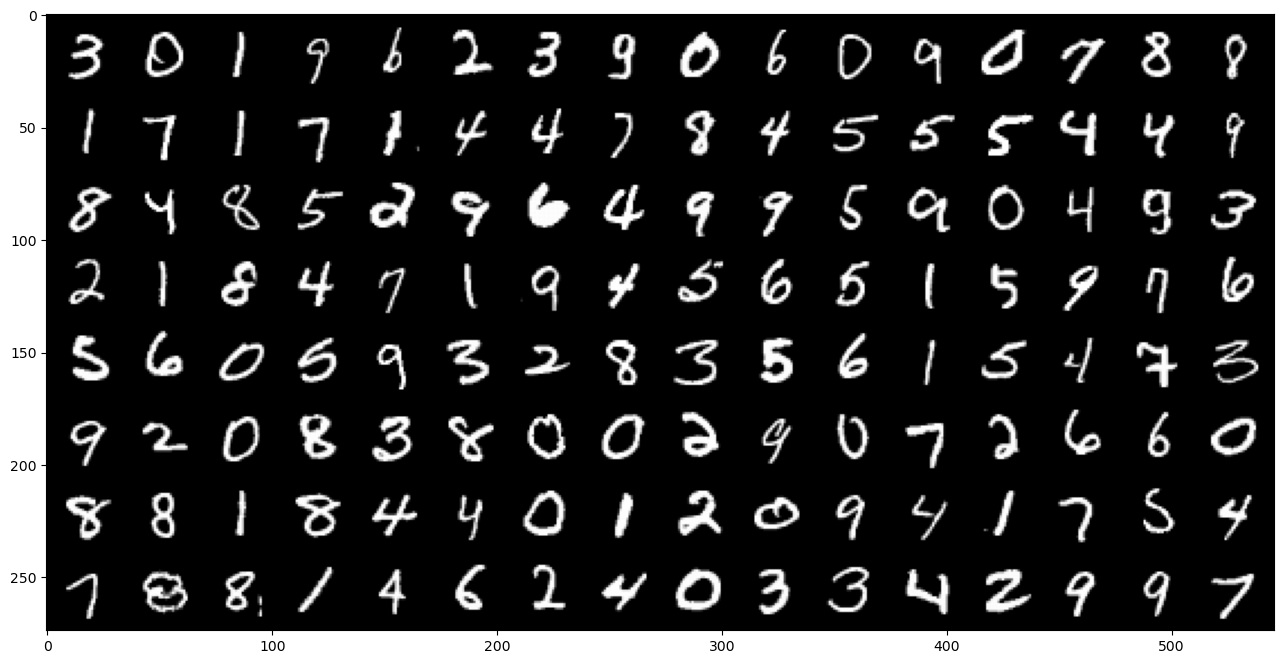

In [4]:
import torchvision.utils
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(dataloaders['train']))

fig = plt.figure(figsize=(16, 8))
out = torchvision.utils.make_grid(images, nrow=16)

plt.imshow(out.permute(1, 2, 0), cmap="gray")

## Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `torch.flatten`.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

    # Layer 2: Convolutional. Input = 14x14x6 Output = 10x10x16.
    self.conv2 = nn.Conv2d(6, 16, 5)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    self.fc1 =  nn.Linear(400, 120)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    self.fc2 = nn.Linear(120, 84)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # Layer 1
    x = self.conv1(x)
    # Activation
    x = F.relu(x)
    # Pooling
    x = F.max_pool2d(x, 2)
    # Layer 2
    x = self.conv2(x)
    # Activation
    x = F.relu(x)
    # Pooling
    x = F.max_pool2d(x, 2)
    # Flatten
    x = torch.flatten(x, 1)
    # Layer 3
    x = self.fc1(x)
    # Activation
    x = F.relu(x)
    # Layer 4
    x = self.fc2(x)
    # Activation
    x = F.relu(x)
    # Layer 5
    x = self.fc3(x)

    return x

## Training Setup
This section defines the model and optimizer to use in training. The train_model function comes from the [PyTorch documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [6]:
import time
import copy

model = LeNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
export_path = "lenet.pt"

# Setup a device for training (use GPU if it's available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
  since = time.time()

  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_acc_history.append(epoch_acc)

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

## Train the Model

In [7]:
model = model.to(device)
model, _ = train_model(model, dataloaders, criterion, optimizer, num_epochs)
torch.save(model, export_path)

Epoch 0/29
----------
train Loss: 0.9111 Acc: 0.7033
val Loss: 0.2247 Acc: 0.9298

Epoch 1/29
----------
train Loss: 0.1435 Acc: 0.9549
val Loss: 0.1204 Acc: 0.9613

Epoch 2/29
----------
train Loss: 0.0919 Acc: 0.9712
val Loss: 0.0973 Acc: 0.9701

Epoch 3/29
----------
train Loss: 0.0702 Acc: 0.9784
val Loss: 0.0791 Acc: 0.9749

Epoch 4/29
----------
train Loss: 0.0570 Acc: 0.9821
val Loss: 0.0654 Acc: 0.9797

Epoch 5/29
----------
train Loss: 0.0472 Acc: 0.9854
val Loss: 0.0591 Acc: 0.9811

Epoch 6/29
----------
train Loss: 0.0418 Acc: 0.9869
val Loss: 0.0577 Acc: 0.9818

Epoch 7/29
----------
train Loss: 0.0363 Acc: 0.9888
val Loss: 0.0670 Acc: 0.9792

Epoch 8/29
----------
train Loss: 0.0320 Acc: 0.9899
val Loss: 0.0589 Acc: 0.9822

Epoch 9/29
----------
train Loss: 0.0301 Acc: 0.9899
val Loss: 0.0515 Acc: 0.9848

Epoch 10/29
----------
train Loss: 0.0265 Acc: 0.9917
val Loss: 0.0507 Acc: 0.9851

Epoch 11/29
----------
train Loss: 0.0231 Acc: 0.9921
val Loss: 0.0524 Acc: 0.9842

Ep

## Evaluation Function
This function is deisgned to evaluate the model.

In [8]:
def evaluate(model, dataloader):
  number_correct_predictions = 0
  number_samples = 0
  with torch.set_grad_enabled(False):
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)
      predicted_logits = model(images)
      predicted_labels = torch.argmax(predicted_logits, dim=1)
      correct_predictions = torch.sum(predicted_labels == labels)
      number_correct_predictions += correct_predictions.item()
      number_samples += len(images)
  return float(number_correct_predictions) / number_samples

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

In [9]:
# Load the best model
model = torch.load("lenet.pt")
model = model.to(device)
model.eval()
test_accuracy = evaluate(model, dataloaders['test'])
print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.989
